In [17]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

hr:  2.9166666666666665


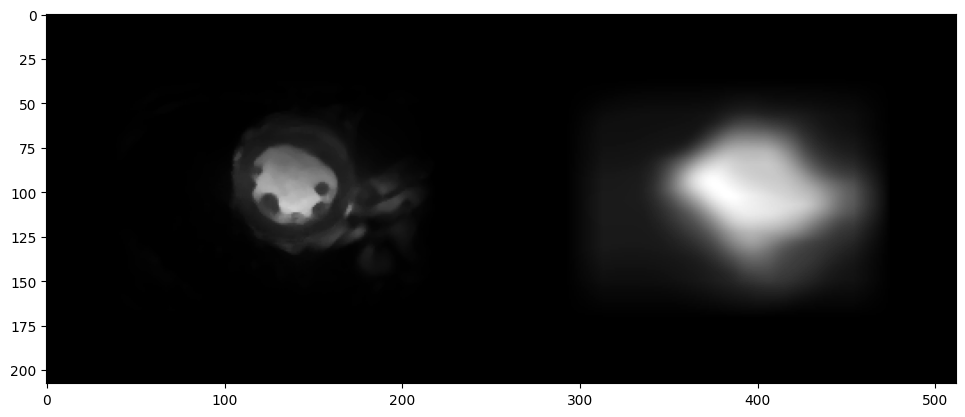

In [77]:
Tps = 0
Slice = 11//3

num = 9

def load_patient(num):
    with open(f'database/training/patient{num:03}/info.cfg') as f:
        info = [line.replace("\n", "").replace(":", "").split(" ") for line in f]
        for i in range(len(info)):
            if info[i][1].isnumeric():
                info[i][1] = int(info[i][1])

    patient = tio.Subject(
        img=tio.ScalarImage(f'database/training/patient{num:03}/patient{num:03}_4d.nii.gz'),
        gt=tio.LabelMap(f'database/training/patient{num:03}/patient{num:03}_frame{dict(info)["ED"]:02}_gt.nii.gz'),
        info = dict(info)
    )
    return patient



def normalize(img4d):
    hist = torch.linspace(0, 1, img4d.shape[1]*img4d.shape[2]*img4d.shape[3], dtype=torch.short)
    hist = torch.pow(hist, 5)*(6-5*hist)*500
    for t in range(img4d.shape[0]):
        indexs = torch.unravel_index(torch.argsort(img4d[t].flatten()), img4d[t].shape)
        img4d[t][indexs] = hist


def tf_mask2(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.ifft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75))

    #mask = cv2.medianBlur(mask,3)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(75,75)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m, mask

patient = load_patient(num)
t_img = patient.img.data.clone().detach()
t_gt = patient.gt.data.clone().detach()
img_m, mask = tf_mask2(t_img, heartrate=t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))
#
# 
# 
# (t_img)
plt.figure().set_figwidth(15)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
plt.imshow(np.concatenate([img_m, mask], axis=1), cmap='gray')

print("hr: ", t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

In [78]:
def patient_metrics(patient, circles, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    center = (t_gt[0, :, :, Slice]==3).argwhere().mean(axis=0, dtype=torch.float32)
    if circles is None:
        return False, 0., False
    
    dist = torch.dist(center, torch.tensor(circles[:2])) 
    gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)
    hit =  (gt_map[0, int(circles[1]), int(circles[0]), Slice] == 3)

    return True, dist, hit

In [20]:
def tf_mask(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)

    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(59,59))
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.dilate(mask, kernel, 1)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.erode(mask, kernel, 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    #mask = cv2.blur(mask,(21, 21))

    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(119,119)), 1)
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(130,130)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
    mask = cv2.blur(mask,(21, 21))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    
    return img_m


In [21]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    
    cv2.circle(cimg,(circles[0],circles[1]),circles[2],(0,255,0),1)
    cv2.circle(cimg,(circles[0],circles[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

def draw_region(imageRGB, lv_seg):
  le_contour = lv_seg - cv2.erode(lv_seg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 1, borderType=cv2.BORDER_CONSTANT, borderValue=0)
  lv_seg = np.bool_(lv_seg)
  le_contour = np.bool_(le_contour)
  imageRGB[lv_seg, 2] = 100
  imageRGB[le_contour, 2] = 255
  return imageRGB

In [22]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image):
    param_min = 0
    param_max = 200
    for _ in range(12):
        param_mean = (param_min + param_max) / 2
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
        
        elif circles is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return None

def best_hough_max(image, param_min=0, param_max=200, max_iter=10):
    param_min = param_min
    param_max = param_max
    out_circles = None
    for _ in range(max_iter):
        param_mean = (param_min + param_max) / 2
        circle = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circle is not None and len(circle[0])==1:
            out_circles = circle[0][0]
            param_min = param_mean

        elif circle is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return out_circles

def best_hough2(image):
    for param1 in range(180, 20, -10):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=1,maxRadius=50)
        
        if circles is not None and len(circles[0])==1:
            return circles[0][0]
    return None

def best_hough3(image): # iterate + max dicothomie
    step = 5
    for param1 in range(180, 20, -step):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=10,maxRadius=50)
        
        if circles is not None:
            for param in range(param1+step, param1, -1):
                circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                    param1=param,param2=param/2,minRadius=10,maxRadius=50)
                if circles is not None and len(circles[0])==1:
                    return circles[0][0]
            #return best_hough_max(image, param_max=param1+step, param_min=param1, max_iter=10)
    return None

In [23]:
def find_seed(patient, Slice=Slice):
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    #normalize(t_img)
    hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
    img_m = tf_mask(t_img, heartrate=hr, Slice=Slice)
    circles = best_hough3(img_m)
    return circles


def recherche_cercles(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed(patient, Slice=slice)
        c_img = draw_cercles(t_img, circles, Slice=slice)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += hit 
        if not hit :
            print(i)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    avg_dist /= nb - miss
    print(f"\n-= results =-\n accuracie: {accuracie / nb * 100}% (over found circles: {accuracie / (nb-miss) * 100})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


In [24]:
recherche_cercles(1)

C:\Users\maell\AppData\Local\Temp\ipykernel_37676\529705466.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\maell\AppData\Local\Temp\ipykernel_37676\529705466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)



-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 35.8760871887207
-===========-


C:\Users\maell\AppData\Local\Temp\ipykernel_37676\2502183264.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)


# LV Segmentation

In [83]:
def dice(patient, lv_seg, Slice=Slice):
    t_gt = torch.tensor(patient.gt.data)
    gt_map = t_gt[0, :, :, Slice]
    gt_map = (gt_map == 3)

    lv_seg = np.bool_(lv_seg)
    gt_map = np.bool_(gt_map)
    inter = np.sum(lv_seg & gt_map)
    
    return 2*inter / (np.sum(lv_seg) + np.sum(gt_map))


In [33]:
def region_growth_1(image,seed,error=10):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    regionplus = [seed]
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)
    
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while regionplus:
        new_p=[]
        for (x,y) in regionplus:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if (moy-image[ny,nx])<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        regionplus.extend(new_p)
        if new_p:
            total_intensity=sum(image[ny,nx] for (nx,ny) in regionplus)
            moy=total_intensity/len(regionplus)
        regionplus=new_p
    taille = np.sum(left_V)
    return left_V, taille

In [34]:
def region_growth_2(image,seed,error=10):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    regionplus=[seed]
    start_moy = []
    for i in range(-2, 3, 1):
        for j in range(-2, 3, 1):
            start_moy += [image[seed[1]+i,seed[0]+j]]
    moy = np.median(start_moy)
    
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while regionplus:
        new_p=[]
        for (x,y) in regionplus:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if abs(image[ny,nx]-moy)<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        regionplus.extend(new_p)
        if new_p:
            total_intensity=sum(image[ny,nx] for (nx,ny) in regionplus)
            moy=total_intensity/len(regionplus)
        regionplus=new_p
    taille = np.sum(left_V)
    return left_V, taille

In [35]:
full_seed = find_seed(patient, Slice=Slice)
print(full_seed)
seed = [int(full_seed[0]), int(full_seed[1])]
rayon = full_seed[2]
print(seed, rayon)

C:\Users\maell\AppData\Local\Temp\ipykernel_37676\529705466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)


[136.5  94.5  19.4]
[136, 94] 19.4


In [63]:
def leftv_seg(patient, error=10, Tps=Tps, Slice=Slice):
    full_seed = find_seed(patient, Slice=Slice)
    if full_seed is None:
        return None
    
    seed = [int(full_seed[0]), int(full_seed[1])]
    rayon = full_seed[2]
    t_img = torch.tensor(patient.img.data)
    img = t_img[Tps,:,:,Slice]
    aire = np.pi*rayon**2
    # img = np.array((t_img[Tps,:,:,Slice]/torch.max(t_img[Tps,:,:,Slice])*255),dtype=np.uint8)
    # img = cv2.medianBlur(img,3)
    # img = np.float64(img)
    treshold = 0
    lv_seg_1, last_taille_1 = region_growth_1(np.array(img),seed, treshold)
    lv_seg_2, last_taille_2 = region_growth_2(np.array(img),seed, treshold)
    sizes_1, sizes_2 = [], []

    step = 8
    methode = 0
    for treshold in range(5, 100, step):
        lv_seg_1, taille_1 = region_growth_1(np.array(img), seed, treshold)
        lv_seg_2, taille_2 = region_growth_2(np.array(img), seed, treshold)
        sizes_1 += [(taille_1 - last_taille_1, treshold-step)]
        last_taille_1 = taille_1
        sizes_2 += [(taille_2 - last_taille_2, treshold-step)]
        last_taille_2 = taille_2

    treshold_1 = max(sizes_1)[1]
    treshold_2 = max(sizes_2)[1]
    _, last_taille_1 = region_growth_1(np.array(img),seed, treshold_1)
    _, last_taille_2 = region_growth_2(np.array(img),seed, treshold_2)
    if last_taille_1 >  aire/4 and last_taille_1 < 4*aire:
        treshold = treshold_1
        methode = 1
    elif last_taille_2 >  aire/4 and last_taille_2 < 4*aire:
        treshold = treshold_2
        if methode == 0:
            methode = 2
    if methode == 0:
        lv_seg_1, taille = region_growth_1(np.array(img), seed, treshold_1)
        lv_seg_2, taille = region_growth_2(np.array(img), seed, treshold_2)
        diff_1 = np.abs(last_taille_1 - aire)
        diff_2 = np.abs(last_taille_2 - aire)
        if diff_1 < diff_2:
            methode = 1
        else:
            methode = 2
    sizes = []
    _, last_taille = region_growth_1(np.array(img),seed, treshold)
    for treshold2 in range(treshold, treshold+step):
        if methode == 1:
            lv_seg, taille = region_growth_1(np.array(img), seed, treshold2)
        else:
            lv_seg, taille = region_growth_2(np.array(img), seed, treshold2)
        sizes += [(taille - last_taille, treshold2-1)]
        last_taille = taille

    treshold = max(sizes)[1]
    if methode == 1:
        lv_seg, taille = region_growth_1(np.array(img), seed, treshold)
    elif methode == 2:
        lv_seg, taille = region_growth_2(np.array(img), seed, treshold)
    return lv_seg

In [81]:
def recherche_lv(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    rad = []
    for i in range (1,nb+1):
        patient = load_patient(i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
        slice = t_img.shape[3] // 2
        circles = find_seed(patient, Slice=slice)
        lv_seg = leftv_seg(patient, Slice=slice)
        if lv_seg is None:
            miss += 1
            continue
        c_img = draw_cercles(t_img, circles, Slice=slice)
        c_img = draw_region(c_img, lv_seg)
        found, dist, hit  = patient_metrics(patient, circles, Slice=slice)

        miss += not found
        avg_dist += dist 
        accuracie += hit 

        
        cv2.imwrite(f'test_seg/cercles_{i:03d}.png', c_img)
        dice_score = dice(patient, lv_seg, slice)
        print(f"{i} : {found} {dist} {hit} and Dice: {dice_score}")
    avg_dist /= nb - miss
    print(f"\n-= results =-\n accuracie: {accuracie / nb * 100}% (over found circles: {accuracie / (nb-miss) * 100})\n miss: {miss} \n avg dist: {avg_dist}\n-===========-")


In [84]:
recherche_lv(10)

C:\Users\maell\AppData\Local\Temp\ipykernel_37676\609551765.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\maell\AppData\Local\Temp\ipykernel_37676\609551765.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_gt = torch.tensor(patient.gt.data, dtype=torch.float32)
C:\Users\maell\AppData\Local\Temp\ipykernel_37676\529705466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)


1 : True 35.8760871887207 True and Dice: 0.8160583941605839
2 : True 28.044910430908203 True and Dice: 0.8241590214067278
3 : True 38.189918518066406 True and Dice: 0.8180677540777918
4 : True 55.09917449951172 True and Dice: 0.7935192162773173
5 : True 17.922470092773438 True and Dice: 0.3682302023628495
6 : True 15.805614471435547 True and Dice: 0.8402366863905325
7 : True 10.19149112701416 True and Dice: 0.8992084432717679
8 : True 41.80229187011719 True and Dice: 0.6378378378378379
9 : True 59.47969436645508 True and Dice: 0.7817019845274134
10 : True 36.27674102783203 True and Dice: 0.9291621718806184

-= results =-
 accuracie: 100.0% (over found circles: 100.0)
 miss: 0 
 avg dist: 33.868839263916016
-===========-


## To do list

- faire une fonction de propagation des seeds qui prend en entrée une image ou placer une seed et une image avec une seed placée. ET appliquer hough dans un voisinage.
- faire une autre fonction qui determine une seed qui est le minimum des distances moyennes à 5 autres seeds.

- tester la segmentation par region growing sur un gradient de l'image (méthodes de edge based region growing)
- tester des normalisations blablabla de l'image pour voir si meilleures performances.